 Raul Jimenez Ayza, NIU: 1688916

# cas Kaggle: League of Legends Ranked Games


Installs neccessaris per funcionament de practica:

In [ ]:
#es para instalar el kaggle-->con ! o %
%pip install kaggle 
%pip install seaborn
%pip install pycaret

     ---------------------------------------- 0.0/82.7 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.7 kB ? eta -:--:--
     ---------------------------------------- 82.7/82.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105802 sha256=51af52b42234f73aaf9d4af14e8a75fb25910cac0cf7399df766079759d6d60a
  Stored in directory: c:\users\nitropc\appdata\local\pip\cache\wheels\ff\55\fb\b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports:

In [ ]:
from zipfile import ZipFile
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
from pycaret.classification import*
import matplotlib.pyplot as plt

Archius del cas:

In [22]:
api = KaggleApi()
#api.config  = os.path.join(os.getcwd(),'kaggle.json')
api.authenticate()

dataser_owner = 'datasnaek'
dataset_name= 'league-of-legends'
dataset = f'{dataser_owner}/{dataset_name}'

if not os.path.isdir('data_kaggle'):
  os.mkdir('data_kaggle')
  api.dataset_download_files(dataset = dataset,path = 'data_kaggle')
  zf = ZipFile(f'data_kaggle/{dataset_name}.zip')
  zf.extractall(f'data_kaggle/{dataset_name}') #save files in selected folder
  zf.close()

df = pd.read_csv(f'data_kaggle/{dataset_name}/games.csv')

print(df.head(10))

       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   
5  3287435705  1501667992132          2059         9       1           2   
6  3314215542  1503430065724          1993         9       1           1   
7  3329224025  1504472363684          1334         9       1           1   
8  3318040883  1503686577549          1387         9       2           2   
9  3327786881  1504385918871          2681         9       2           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  t2_towerKills  \
0           1               1           1            1  ...              5   
1      

In [23]:
numero = df.shape[1]
noms = df.columns.tolist()
print("Número d'atributs:", numero)
print("Atributs:", noms)

Número d'atributs: 61
Atributs: ['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']

In [20]:
df.info()
df["winner"].unique()
df=df[['winner','firstBlood','firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald','t1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills','t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills',]]

print("\nNulls:")
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   winner              51490 non-null  int64
 1   firstBlood          51490 non-null  int64
 2   firstTower          51490 non-null  int64
 3   firstInhibitor      51490 non-null  int64
 4   firstBaron          51490 non-null  int64
 5   firstDragon         51490 non-null  int64
 6   firstRiftHerald     51490 non-null  int64
 7   t1_towerKills       51490 non-null  int64
 8   t1_inhibitorKills   51490 non-null  int64
 9   t1_baronKills       51490 non-null  int64
 10  t1_dragonKills      51490 non-null  int64
 11  t1_riftHeraldKills  51490 non-null  int64
 12  t2_towerKills       51490 non-null  int64
 13  t2_inhibitorKills   51490 non-null  int64
 14  t2_baronKills       51490 non-null  int64
 15  t2_dragonKills      51490 non-null  int64
 16  t2_riftHeraldKills  51490 non-null  int6

winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t2_towerKills         0
t2_inhibitorKills     0
t2_baronKills         0
t2_dragonKills        0
t2_riftHeraldKills    0
dtype: int64

In [13]:
print(df.dtypes['winner'])
print(df['winner'].unique())

int64
[1 2]


In [14]:
# Tamaño de los datos de entrenamiento
print("Tamaño de los datos de entrenamiento:", df.shape)

Tamaño de los datos de entrenamiento: (51490, 17)


c:\Users\raulj\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


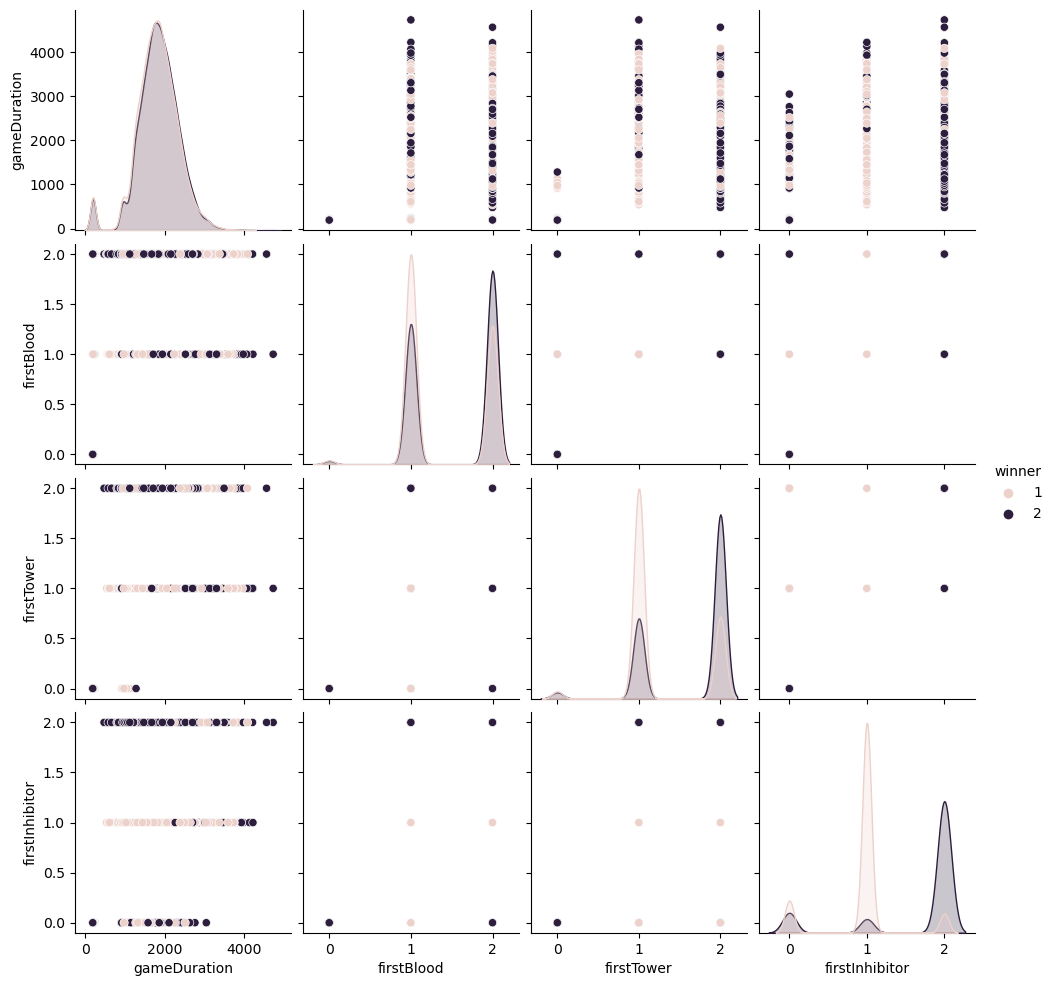

In [ ]:
dfPlot = df.iloc[:,:5]
sns.pairplot(dfPlot, hue='winner')

In [ ]:
setup(df,target="winner")
compare_models()

,Description,Value
0,Session id,252
1,Target,winner
2,Target type,Binary
3,Target mapping,"1: 0, 2: 1"
4,Original data shape,"(51490, 17)"
5,Transformed data shape,"(51490, 17)"
6,Transformed train set shape,"(36043, 17)"
7,Transformed test set shape,"(15447, 17)"
8,Numeric features,16
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9720,0.9975,0.9720,0.9720,0.9719,0.9439,0.9439,0.2460
gbc,Gradient Boosting Classifier,0.9713,0.9975,0.9713,0.9713,0.9713,0.9425,0.9426,0.9120
rf,Random Forest Classifier,0.9700,0.9969,0.9700,0.9700,0.9700,0.9400,0.9400,0.4880
et,Extra Trees Classifier,0.9695,0.9962,0.9695,0.9696,0.9695,0.9390,0.9391,0.5620
ada,Ada Boost Classifier,0.9661,0.9967,0.9661,0.9663,0.9661,0.9321,0.9323,0.3280
knn,K Neighbors Classifier,0.9649,0.9921,0.9649,0.9650,0.9649,0.9298,0.9299,0.4620
dt,Decision Tree Classifier,0.9626,0.9722,0.9626,0.9626,0.9626,0.9252,0.9252,0.0400
lr,Logistic Regression,0.9601,0.9950,0.9601,0.9604,0.9601,0.9203,0.9205,1.0170
ridge,Ridge Classifier,0.9590,0.9944,0.9590,0.9593,0.9590,0.9180,0.9183,0.0290
lda,Linear Discriminant Analysis,0.9590,0.9944,0.9590,0.9593,0.9590,0.9180,0.9183,0.0600


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=252, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9717,0.9975,0.9717,0.9717,0.9717,0.9434,0.9434
1,0.9731,0.9976,0.9731,0.9732,0.9731,0.9462,0.9463
2,0.9723,0.9974,0.9723,0.9723,0.9723,0.9445,0.9446
3,0.9711,0.9974,0.9711,0.9711,0.9711,0.9423,0.9423
4,0.9731,0.9973,0.9731,0.9732,0.9731,0.9462,0.9462
5,0.9714,0.9977,0.9714,0.9715,0.9714,0.9428,0.9429
6,0.9725,0.9977,0.9725,0.9725,0.9725,0.9450,0.9451
7,0.9686,0.9970,0.9686,0.9686,0.9686,0.9373,0.9373
8,0.9739,0.9979,0.9739,0.9740,0.9739,0.9478,0.9479


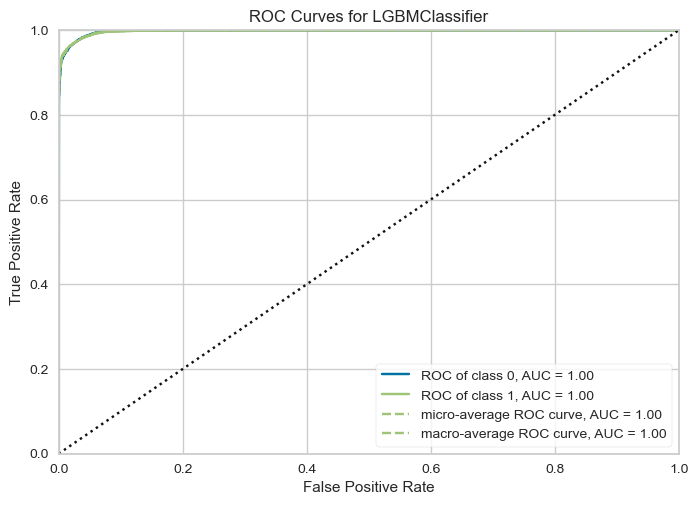

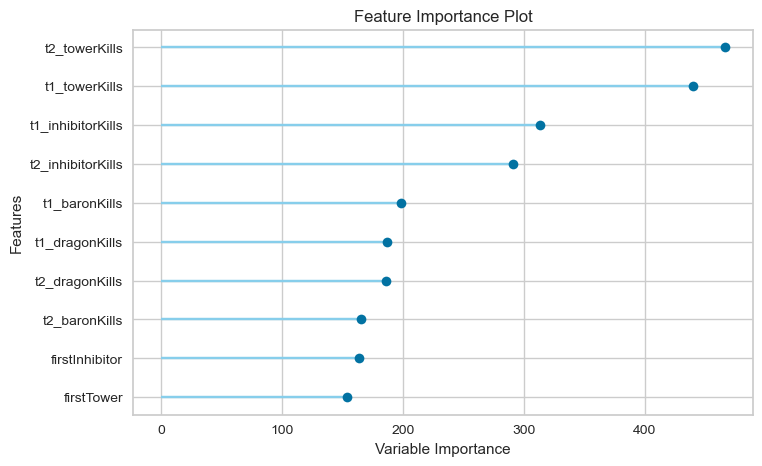

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=252, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
best_model=create_model("lightgbm")
plot_model(best_model, plot = 'auc')
plot_model(best_model,plot="feature")
best_model

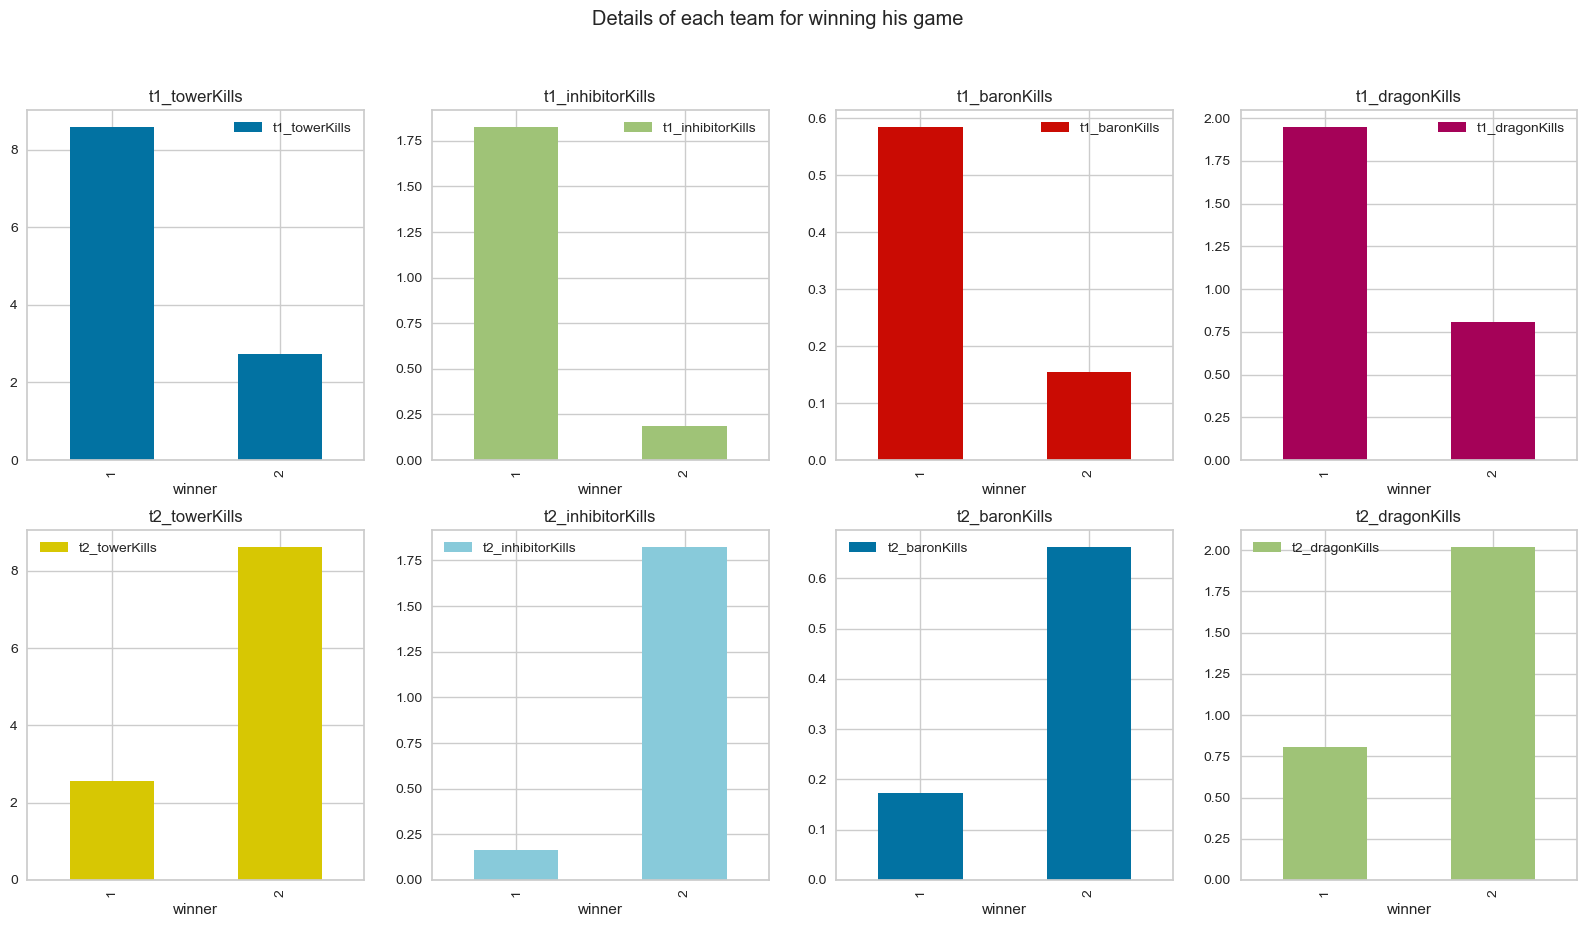

In [ ]:
Towers_Barons_Drakes_Inhib=df[["winner","t1_towerKills","t1_inhibitorKills","t1_baronKills","t1_dragonKills","t2_towerKills","t2_inhibitorKills","t2_baronKills","t2_dragonKills"]]
Towers_Barons_Drakes_Inhib.groupby("winner").mean()
Towers_Barons_Drakes_Inhib.groupby("winner").mean().plot(kind="bar",subplots=True,sharex=False,sharey=False,figsize=(20,10),layout=(2,4),title="Details of each team for winning his game")
plt.show()